## Spectral Clustering
Steps followed for the spectral clustering:
1. Load the similarity matrix and node names (games)
2. Build the normalized Laplacian (appropriate for k>2 clusters)
3. Compute the spectral embedding from the smallest eigenvalues of the Laplacian
4. Apply k-means on the spectral embedding and evaluate the clustering (DB score)
5. Save results, visualize cluster sizes

Two similarity matrices evaluated:
- one based on TF-IDF vectorization + cosine similarity
- another constructed using shingling + hashing + LSH + Jaccard similarity

In [ ]:
import numpy as np
import scipy.sparse as sp
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.sparse.linalg import eigsh 
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# -----------------------------------------------------------
# 1. LOAD SIMILARITY MATRIX

# Load similarity matrix and node names (games)
# with h5py.File(path, "r") as f:
#    print(list(f.keys())) -> ['matrix', 'node_names']

# Path to precomputed similarity matrix S (TF-IDF + cosine similarity)
DATA = Path("./data")

GEN_DATA = DATA / "gen"
RAW_DATA = DATA / "raw"
path = GEN_DATA / "gam_sim_small_lemma.h5"

with h5py.File(path, "r") as f:
    S = f["matrix"][:]
    raw_names = np.array(f["node_names"][:])
# print("Similarity matrix shape:", S.shape) -> Dense similarity matrix: size (11112, 11112)

# print(type(raw_names[0])) -> <class 'bytes'>
# Decode node names from bytes to normal strings
names = np.array([name.decode('utf-8') for name in raw_names])

# -----------------------------------------------------------
# 2. BUILD THE NORMALIZED LAPLACIAN

# A = adjacency matrix of the graph
# Considering S as the adjacency matrix
A = sp.csr_matrix(S)

# D = degree matrix (diagonal)
degrees = np.array(A.sum(axis=1)).flatten()
D_inv_sqrt = sp.diags(1.0 / np.sqrt(degrees + 1e-12))  # D^{-1/2};add small value to avoid division by zero

# L = normalized Laplacian: L = I - D^{-1/2} A D^{-1/2}
L = (sp.eye(A.shape[0], format="csr") - D_inv_sqrt @ A @ D_inv_sqrt).tocsr()

# -----------------------------------------------------------
# 3. SPECTRAL EMBEDDING (U) USING k SMALLEST EIGENVECTORS

# Choose number of clusters (after evaluation for various k values)
k=400

# Compute the k smallest eigenvalues/eigenvectors of L
#these correspond to λ_1, λ_2,..., λ_k
eigvals, eigvecs = eigsh(L, k=k, which="SM")

#  U = matrix with eigenvectors as columns
U = eigvecs
# Normalize rows of U (as in normalized spectral clustering)
U_norm = U / (np.linalg.norm(U, axis=1, keepdims=True) + 1e-12)

# -----------------------------------------------------------
# 4. APPLY k-MEANS ON THE SPECTRAL EMBEDDING

# Cluster rows of U_norm using k-means 
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(U_norm)

# Evaluate clustering quality using Davies-Bouldin score
db_score = davies_bouldin_score(U_norm, labels)

print("Clustering completed. Number of clusters:", k)
print(f"Davies-Bouldin score: {db_score:.4f}")

Clustering completed. Number of clusters: 400
Davies-Bouldin score: 0.3548


Cluster assignments saved to ./data/gen/spectral_cluster_labels_matrix2.npy
CSV file saved


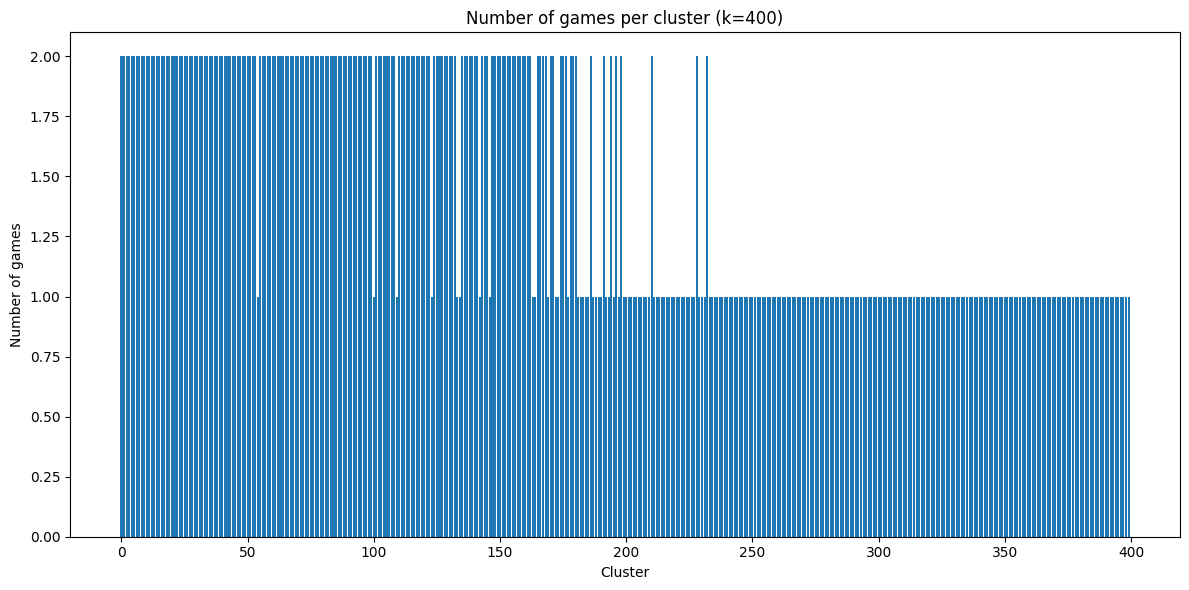

Cluster sizes (cluster_id -> size):
0: 2
1: 2
2: 2
3: 2
4: 2
5: 2
6: 2
7: 2
8: 2
9: 2
10: 2
11: 2
12: 2
13: 2
14: 2
15: 2
16: 2
17: 2
18: 2
19: 2


In [ ]:
# 5. SAVE RESULTS AND VISUALIZE CLUSTER SIZES
import pandas as pd

cluster_assignments = {
    "game": names,
    "cluster": labels
}
save_path = "./data/gen/spectral_cluster_labels_matrix2.npy"
np.save(save_path, cluster_assignments)
print(f"Cluster assignments saved to {save_path}")

df = pd.DataFrame({
    "name": names,
    "cluster": labels
})
df.to_csv("./data/gen/spectral_cluster_labels_matrix2.csv", index=False)
print("CSV file saved")
# -----------------------------------------------------------
# Bar plot with the number of games per cluster
unique_clusters, cluster_counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_clusters, cluster_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of games")
plt.title(f"Number of games per cluster (k={k})")
plt.tight_layout()
plt.show()
# Print the sizes of the largest clusters
cluster_sizes = dict(zip(unique_clusters, cluster_counts))
print("Cluster sizes (cluster_id -> size):")
for c, size in sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{c}: {size}")

## Spectral clustering using sklearn package:
It does not perform well for a dense similarity matrix, as it can be seen in the plot of cluster sizes. Some of them are very large while the others are much more small in comparison, thereby the previous approach has better results

In [6]:
import numpy as np
import scipy.sparse as sp
import h5py
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load similarity matrix and node names (games)
# with h5py.File(path, "r") as f:
#    print(list(f.keys())) -> ['matrix', 'node_names']

# Path to precomputed similarity matrix S (TF-IDF + cosine similarity)
path = "./data/gen/game_similarity_tfidf.h5"

with h5py.File(path, "r") as f:
    S = f["matrix"][:]
    raw_names = np.array(f["node_names"][:])
# print("Similarity matrix shape:", S.shape) -> Dense similarity matrix: size (11112, 11112)

# print(type(raw_names[0])) -> <class 'bytes'>
# Decode node names from bytes to normal strings
names = np.array([name.decode('utf-8') for name in raw_names])


# SPECTRAL CLUSTERING WITH SKLEARN

k=400
sc = SpectralClustering(
    n_clusters=k,
    affinity="precomputed",   
    assign_labels="kmeans",
    random_state=42
)
labels = sc.fit_predict(S)

print("Clustering completed. Number of clusters:", k)

unique_clusters, cluster_counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_clusters, cluster_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of games")
plt.title(f"Number of games per cluster (k={k})")
plt.tight_layout()
plt.show()

# Print the sizes of the largest clusters
cluster_sizes = dict(zip(unique_clusters, cluster_counts))
print("Cluster sizes (cluster_id -> size):")
for c, size in sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{c}: {size}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './data/gen/game_similarity_tfidf.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)